## Teoria

Parte-se do pressuposto que os dados estão organizados da seguinte maneira, numa matriz $R$

User_ID | Item_1 | $\dots$ | Item_n 

, e cada célula contém a avaliação do usuário User_m para o item da coluna específica, caso o usuário não tenha avaliado o item, colocamos um valor default de 0.

O primeiro passo seria pegar esses dados e dividí-los nas matrizes $M_1$ e $M_2$, uma que diz respeito aos usuários e outra que diz respeito aos usuários e suas caracteristicas e a outra diz respeito aos itens e suas características.

As duas matrizes são iniciadas com valores aleatórios.
Após inicializar essas duas matrizes, é preciso criar a matriz $\hat{R}$, que terá uma configuração do tipo, 

User_ID | Item_1 | Item_2 | $\dots$ | Item_n

E cada célula será preenchida com um valor de "Rating", que por sua vez será resultado da seguinte multiplicação, 

$$ \hat{R} = M_1 \times M_2^T $$
Ok, temos uma matriz $\hat{R}$, formada pela multiplicação de valores aleatórios, e portanto, tem vários valores aleatórios. A questão é:

Como isso será útil para sistemas de recomendação? 

Realmente inicialmente não teremos resultados satisfatórios tendo em vista que só tivemos a utilização de valores aleatórios. Porém, para melhorarmos isso, utilizaremos algoritmos de otimização como o SGD, para que os valores das matrizes $M_1$ e $M_2$ sejam ajustados e fiquem mais condizentes com os valores da matriz de avaliações $R$.
Ao final desse processo teremos uma matriz de recomendação $\hat{R}$, com valores condizentes com a realidade dos dados. Abaixo temos a classe MatrixFactorization completa.

## Implementação

In [2]:
import numpy as np
import pandas as pd

In [3]:
class MatrixFactorization():
    def __init__(self, number_caracteristics=50, learning_rate=0.1, max_iter=500, regularization=0.01, momentum=0.9):        
        self.number_caracteristics = number_caracteristics # tamanho de cada embedding 
        self.learning_rate = learning_rate # learning rate do gradiente descendente 
        self.max_iter = max_iter 
        self.regularization = regularization #fator de regularização 
        self.momentum = momentum  # inicialmente eu não tinha colocado o termo de momentum 

    def criar_matrizes(self, Matriz_R):

        # cria as matrizes de usuário e item que vao ser usadas para a criacao da matriz r_hat
        self.user_matrix = np.random.random(size=(Matriz_R.shape[0], self.number_caracteristics))
        self.item_matrix = np.random.random(size=(Matriz_R.shape[1], self.number_caracteristics))
        
    def criar_matriz_R_hat(self):

        self.r_hat = np.dot(self.user_matrix, self.item_matrix.T)
    
    def calcular_erro(self, Matriz_R):

        erro = (Matriz_R - (self.user_matrix @ self.item_matrix.T)) 
        mse = np.mean(erro ** 2)
        return np.sqrt(mse)


    def calcular_gradientes(self, Matriz_R):

        # aqui é a ideia de criar uma máscara para os valores que não foram avaliados pelos usuários
        # retirado do github https://github.com/wangyuhsin/matrix-factorization/blob/main/README.md   

        array_r = np.array(Matriz_R)
        mask = np.where(array_r != 0, 1, 0)
        n = mask.sum() 

        pred_user = (self.user_matrix @ self.item_matrix.T) * mask
        pred_item = (self.item_matrix @ self.user_matrix.T).T * mask

        grad_user = -2 /n * np.dot ((array_r - pred_user), self.item_matrix)
        grad_itens = -2/n * np.dot((array_r - pred_item).T, self.user_matrix)
        return grad_user, grad_itens
    

    def treinar(self, Matriz_R, mostrar_erro=False):
        array_R = np.array(Matriz_R)        

        self.erros_iteracoes = []
 
        v_user = np.zeros_like(self.user_matrix)
        v_items = np.zeros_like(self.item_matrix)

        for iter in range(self.max_iter):
            
            user_grad, items_grad = self.calcular_gradientes(Matriz_R)

            v_user = self.momentum * v_user + self.regularization * user_grad 
            v_items = self.momentum * v_items + self.regularization * items_grad
            
            self.user_matrix -= self.learning_rate * v_user
            self.item_matrix -= self.learning_rate * v_items

            if mostrar_erro:
                    if iter %10 == 0:
                        erro_atual = self.calcular_erro(array_R)
                        print(f"Iteração: {iter + 1}, Erro: {erro_atual}") 
                        self.erros_iteracoes.append(erro_atual)
      
        
        self.r_hat = np.dot(self.user_matrix, self.item_matrix.T)
        return self.r_hat

    def fit(self, Matriz_R, mostrar_erro=False, salvar = False):
        self.criar_matrizes(Matriz_R)
        self.criar_matriz_R_hat()  
        if salvar: 
            np.save("matriz_r_hat",self.r_hat)
            np.save("matriz_m1", self.user_matrix)
            np.save("matriz_m2", self.item_matrix)
            R_hat_df = pd.DataFrame(self.r_hat, columns= Matriz_R.columns)
            R_hat_df.to_csv("Matriz_R_hat.csv")
        return self.treinar(Matriz_R, mostrar_erro)


## Testes

Como dito no início, aqui se pressupõe que os valores estão organizados de determinada maneira, para isso peguei o dataset do Movielens100k pivoteado.

Caso seja de interesse do leitor, a limpeza do dataset está disponível em 

https://github.com/Lucasaraga0/k_means_recommendation-system/blob/main/notebooks_and_functions/datasets_cleaning.ipynb

Desse mesmo repositório utilizarei o dataset Movie_pivot_1.csv. 

In [4]:
Matriz_R = pd.read_csv("movies_pivot_1.csv")
Matriz_R.fillna(0,inplace= True)
Matriz_R.drop(columns= ['User Average Rating'], inplace= True)
Matriz_R

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998).1,You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
MatrizF = MatrixFactorization(number_caracteristics= 100, max_iter= 4000, regularization = 0.1, learning_rate= 0.5, momentum= 0.9 )
MatrizF.fit(Matriz_R= Matriz_R,mostrar_erro= True)

Iteração: 1, Erro: 24.83125780549256
Iteração: 11, Erro: 21.480960417894714
Iteração: 21, Erro: 18.206541955737237
Iteração: 31, Erro: 16.31893933221143
Iteração: 41, Erro: 15.234145774414321
Iteração: 51, Erro: 14.549906127423059
Iteração: 61, Erro: 14.071296734959644
Iteração: 71, Erro: 13.70455203707042
Iteração: 81, Erro: 13.403636284176782
Iteração: 91, Erro: 13.1452722229715
Iteração: 101, Erro: 12.917118909185229
Iteração: 111, Erro: 12.712082586814129
Iteração: 121, Erro: 12.525659711286153
Iteração: 131, Erro: 12.354719298184998
Iteração: 141, Erro: 12.19692696282726
Iteração: 151, Erro: 12.050457721575276
Iteração: 161, Erro: 11.913841900720621
Iteração: 171, Erro: 11.785873578970259
Iteração: 181, Erro: 11.665550147842907
Iteração: 191, Erro: 11.552029122957554
Iteração: 201, Erro: 11.44459591422119
Iteração: 211, Erro: 11.34263932446794
Iteração: 221, Erro: 11.245632715988357
Iteração: 231, Erro: 11.153119348466614
Iteração: 241, Erro: 11.064700796659068
Iteração: 251, Erro

array([[ 4.37349715,  3.09246226,  2.95077939, ...,  4.48547045,
         4.63290511,  5.78374831],
       [ 3.71861237,  5.46772783,  4.68356278, ...,  9.6822184 ,
         8.13159638,  8.18602355],
       [ 3.17060565,  3.7851962 ,  3.4136815 , ...,  8.5809606 ,
         7.99929901,  7.95428641],
       ...,
       [ 4.56880684,  6.50099373,  5.41416808, ...,  9.91802145,
        11.38217841, 10.5891448 ],
       [ 3.99321965,  3.64509583,  5.10983416, ...,  8.62369579,
         6.56349394,  7.93479783],
       [ 4.34453228,  3.92328618,  2.9814902 , ...,  6.12324681,
         3.99392523,  4.81893179]])

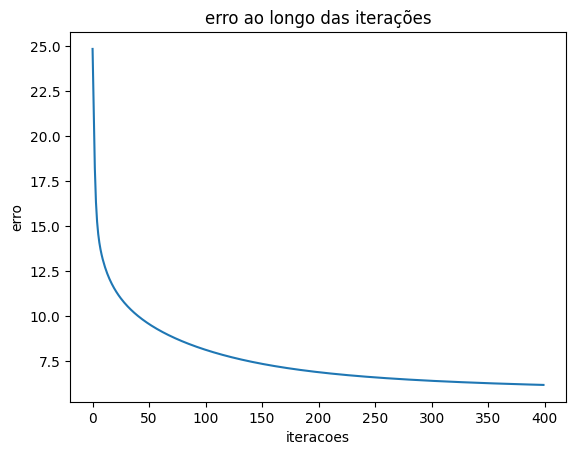

In [6]:
import matplotlib.pyplot as plt

erros = MatrizF.erros_iteracoes
plt.plot(erros)
plt.xlabel("iteracoes")
plt.ylabel("erro")
plt.title("erro ao longo das iterações")
plt.show()

## Teste

Exemplo de recomendação para um usuário

In [7]:
## escolhemos um usuario

User_number = np.random.randint(low = 0, high= Matriz_R.shape[0])

#podemos ver quais são aqueles filmes melhores avaliados pelos usuarios

user_best_ratings = Matriz_R.iloc[User_number].nlargest(10).index.to_list()
user_best_ratings 

['While You Were Sleeping (1995)',
 'Sleepless in Seattle (1993)',
 'Raiders of the Lost Ark (1981)',
 'Apt Pupil (1998)',
 'As Good As It Gets (1997)',
 'Pretty Woman (1990)',
 'Silence of the Lambs, The (1991)',
 'Fargo (1996)',
 'Godfather, The (1972)',
 'Fish Called Wanda, A (1988)']

In [8]:
#depois disso a gente vai na matrix_r_hat e pega dentre os filmes que nao foram assistidos pelo usuario aqueles com a maior nota

def pegar_recomendacoes(user_number, number_recomendations, matriz_r, matrizr_hat = None, prints = True):
    if matrizr_hat is None:
        Mf = MatrixFactorization(number_caracteristics= number_recomendations*5)
        Mf.fit(matriz_r)
        matrizr_hat = Mf.r_hat
        
    matrizr_hat = pd.DataFrame(matrizr_hat, columns= matriz_r.columns)
    
    #tendo a matriz de recomendacoes r_hat basta pegar os que tem maior avaliacao e não foram avaliadas pelo usuario
    
    real = matriz_r[user_number: user_number+1]
    rec = matrizr_hat[user_number: user_number+1]
    
    for column in real.columns:
        if real.at[user_number, column] != 0:
            rec.at[user_number, column] = 0
    lista_rec = rec.iloc[0].nlargest(number_recomendations).index.tolist()
    if prints:
        print("Buscando recomendações para você ...")
        print("Talvez você goste de:")
        
        for i,element in enumerate(lista_rec):
            if (i+1) %3 != 0 and i+1 != len(lista_rec) :
                print(element, end = ", ")
            else:
                print(element)
    return lista_rec

lista_recomendacoes = pegar_recomendacoes(User_number, number_recomendations= 10, matriz_r = Matriz_R, matrizr_hat= MatrizF.r_hat)

Buscando recomendações para você ...
Talvez você goste de:
Amityville 3-D (1983), Fausto (1993), Butterfly Kiss (1995)
Tainted (1998), Nothing Personal (1995), Lady of Burlesque (1943)
Two Friends (1986) , Witness (1985), Gilligan's Island: The Movie (1998)
S.F.W. (1994)
